## Tutorial 07: Evaluate solution using cost functions

With our implementation of the cost functions from the CommonOcean benchmark, solutions of scenarios can be assessed
locally. More details about the cost functions can be found [here](https://commonocean.cps.cit.tum.de/).

/home/maioneb/.conda/envs/co38/lib/python3.8/site-packages/commonocean/visualization/traffic_sign.py:159: UserWarning: No png file for traffic sign id TrafficSignElementID.LATERAL_MARK_RED_A exists under path /home/maioneb/.conda/envs/co38/lib/python3.8/site-packages/commonocean/visualization/traffic_signs/101.png, skipped plotting.
  warnings.warn(


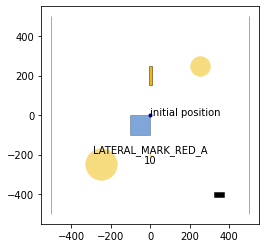

In [1]:
import matplotlib.pyplot as plt
import numpy as np
from commonocean.common.file_reader import CommonOceanFileReader
from commonocean.common.solution import CommonOceanSolutionReader
from commonocean_dc.costs.evaluation import CostFunctionEvaluator
from commonocean.visualization.draw_dispatch_cr import draw_object
from commonocean.scenario.state import GeneralState
from commonocean.scenario.trajectory import Trajectory

scenario, planning_problem_set = CommonOceanFileReader("CommonOceanDC_Tutorial.xml").open()

# Visualize our example scenario
for j in [0,50, 105, 150]:
    draw_object(scenario, draw_params={'time_begin': j, 'trajectory_steps': 0})
    draw_object(planning_problem_set, draw_params={'time_begin': j})
    plt.gca().set_aspect('equal')
    plt.show()

The solution object can either be read from a CommonOcean solution xml file (check [our IO tutorials](https://commonocean.cps.cit.tum.de/commonocean-io) to learn how to create one), or can be created on the fly from a `Trajectory`.

In this example we use an xml file that we are going to create just now.

Suppose you have a trajectory (found by any methodology) and you want to evaluate it.

Let's first build a fictional trajectory for our example scenario.

In [2]:
dt = 1
initial_position_ego_vehicle = np.array([0,0])
goal_center_ego_vehicle = np.array([100,100])
velocity = 5
heading = 3.141621/4
ego_vehicle_initial_state = GeneralState(**{'position': initial_position_ego_vehicle, 'orientation': heading, 'time_step': 0, 'velocity': velocity})
ego_vehicle_state_list = [ego_vehicle_initial_state]
t_max_ego_vehicle = (np.linalg.norm(goal_center_ego_vehicle-initial_position_ego_vehicle)) / velocity
t_end_ego_vehicle = int(t_max_ego_vehicle / dt)
length_dynamic_obstacles = 50
fraction_width_dynamic_obstacles = 2

for t_i in range(1,t_end_ego_vehicle):
    # Computing new position
    new_position = ego_vehicle_state_list[-1].position + \
                np.array([ego_vehicle_state_list[-1].velocity * scenario.dt * np.cos(ego_vehicle_state_list[-1].orientation),
                            ego_vehicle_state_list[-1].velocity * scenario.dt * np.sin(ego_vehicle_state_list[-1].orientation)])

    # Adding new state to ego_vehicle_state_list
    ego_vehicle_state_list.append(GeneralState(**{'position': new_position, 'orientation': heading,'time_step': t_i, 'velocity': velocity}))

heading = 3*3.141621/4

for t_i_2 in range(1,t_end_ego_vehicle):
    # Computing new position
    new_position = ego_vehicle_state_list[-1].position + \
                np.array([ego_vehicle_state_list[-1].velocity * scenario.dt * np.cos(ego_vehicle_state_list[-1].orientation),
                            ego_vehicle_state_list[-1].velocity * scenario.dt * np.sin(ego_vehicle_state_list[-1].orientation)])

    # Adding new state to ego_vehicle_state_list
    ego_vehicle_state_list.append(GeneralState(**{'position': new_position, 'orientation': heading,'time_step': t_i + t_i_2, 'velocity': velocity}))

    
# Creating the predicted trajectory starting at time step 1
ego_vehicle_trajectory = Trajectory(initial_time_step=1, state_list=ego_vehicle_state_list[1:])

After creating the trajectory, let's export our solution file (considering hipothetically that the vessel type, model and the cost function were defined accordingly to the restrictions of our [documentation](https://commonocean.cps.cit.tum.de/commonocean-io)). Note that the vessel model is totally connected with the state variables that you gave in your trajectory. For instance, modify the vessel model (to PM, VP or TF) of the next cell to check that an error is raised.

In [3]:
from commonocean.common.solution import CommonOceanSolutionWriter, Solution, PlanningProblemSolution, VesselModel, VesselType, CostFunction

pps = PlanningProblemSolution(planning_problem_id=9,
                              vessel_type=VesselType.Vessel1,
                              vessel_model=VesselModel.YP,
                              cost_function=CostFunction.SB1,
                              trajectory=ego_vehicle_trajectory)

# define the object with necessary attributes.
solution = Solution(scenario.scenario_id, [pps])

# write solution to a xml file
csw = CommonOceanSolutionWriter(solution)
csw.write_to_file(overwrite=True)

Now, to last, we evaluate our solution considering the model and the cost function chosen. The cost function used is the one referenced in the paper (it uses the time, the acceleration and the COLREGS logic). For more information, check our [publications](https://commonocean.cps.cit.tum.de/publications).

In [4]:
solution = CommonOceanSolutionReader.open("solution_YP1:SB1:ZAM_Tutorial-1_1_T-1:2022a.xml")

ce = CostFunctionEvaluator.init_from_solution(solution)
cost_result = ce.evaluate_solution(scenario, planning_problem_set, solution)

print(cost_result)

Total costs for benchmark YP1:SB1:ZAM_Tutorial-1_1_T-1:2022a:
205.3
Partial costs for solution of planning problem 9:
T:	5.300000000000001
A:	0.0
R:	200


Our ego vessel does not comply with rule 01 (safe distance to other vessels), so it was expected to receive a large value in the R term. In addition, as our ego trajectory had constant velocity, we observe a null cost in the acceleration term.